<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Aplicaciones Recientes de Redes Neuronales </H3>
<H3 align='center'> Pregunta 4 - Distintos tipos de autoencoders (AEs) en MNIST</H3>
<hr style="height:2px;border:none"/>

**Librerias**

In [0]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from google.colab import drive

In [3]:
import keras.backend as K
from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Reshape
from keras.layers import Lambda, UpSampling2D, Conv2DTranspose, Activation
from keras.models import load_model, Model
from keras.metrics import binary_crossentropy, mean_squared_error, mean_squared_logarithmic_error, logcosh

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

Using TensorFlow backend.


In [17]:
fdir = 'gdrive/My Drive/Colab Notebooks/'
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Dataset**

A continuación se carga el dataset `MNIST` en `keras`, sobre imágenes de 28 x 28 pixeles de dígitos manuscritos. Se usa la separación entre conjuntos de entrenamiento y de testing que viene por defecto en el dataset. Luego, a los sets `x_train` y `x_test` se agrega una dimensión más para representar el único canal de las imagenes. Con esto, las dimensiones quedan como `(#ejemplos, 28, 28, 1)`. Finalmente, se reescalan los datos al rango $[0, 1]$, dividiendolos por 255.

In [0]:
from keras.datasets import mnist

# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Canales en formato channels_last
x_train = x_train[:,:,:,None]
x_test = x_test[:,:,:,None]
# Dimensiones
img_rows, img_cols, channel = x_train.shape[1:]
original_img_size = (img_rows, img_cols, channel) # input image dimensions
# Normalizado
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255. 

In [0]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

**Descripción**

El dataset corresponde a 70000 imágenes de 28 × 28 pixeles de un solo canal. El set de entrenamiento tiene 6.000 ejemplos y 1.000 el de testing. En los histogramas de más abajo, se muestra que los ejemplos no están equitativamente distribuidos entre los diez digitos, pero no es una distribución que sea muy dispareja. Es decir, no hay una clase (o un grupo de clases) que tenga muchos más ejemplos que el resto.

En las imágenes que siguen se puede apreciar que los dibujos de los digitos están bien definidos y tienen buen contraste con el fondo. También, se puede adelantar que algunos digitos pueden ser más dificiles de distinguir entre sí, por ejemplo,  $4$, $9$ y $7$; $7$ y $1$; $0$, $6$ y $5$; $3$ y $8$.

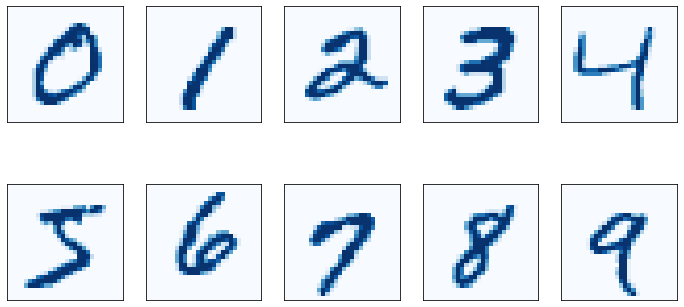

In [0]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i in range(2):
  for j in range(5):
    k = np.argmax(y_train == 5*i +j)
    axes[i][j].imshow(x_train[k,:,:,0], cmap='Blues')
    axes[i][j].get_xaxis().set_visible(False)
    axes[i][j].get_yaxis().set_visible(False)
plt.show()

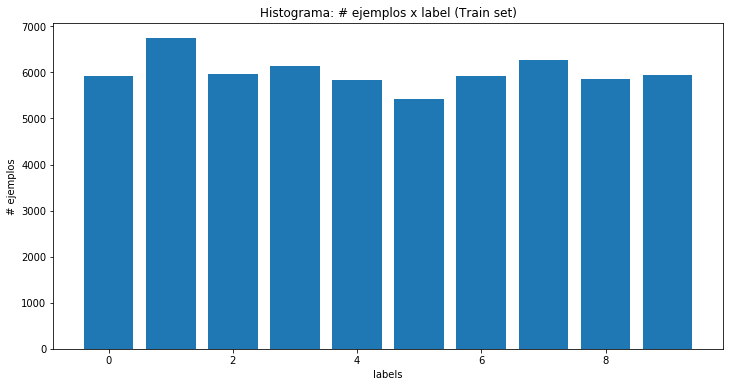

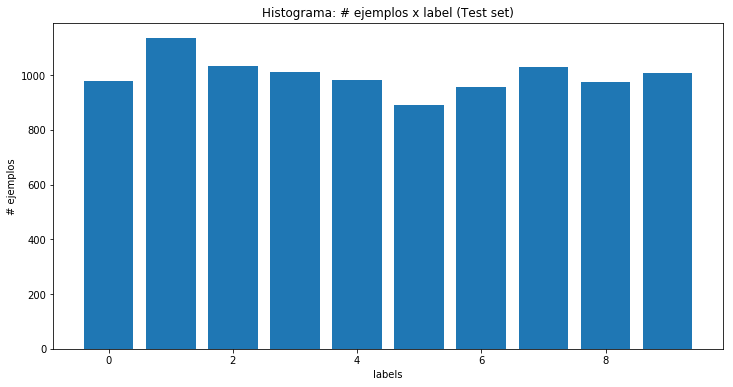

In [7]:
# Cuenta n° ejemplos x clase
labels_hist = pd.Series(y_train).value_counts().sort_index()
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(labels_hist.index, labels_hist.values)
ax.set_xlabel('labels')
ax.set_ylabel('# ejemplos')
ax.set_title("Histograma: # ejemplos x label (Train set)")
plt.show()
print()
labels_hist = pd.Series(y_test).value_counts().sort_index()
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(labels_hist.index, labels_hist.values)
ax.set_xlabel('labels')
ax.set_ylabel('# ejemplos')
ax.set_title("Histograma: # ejemplos x label (Test set)")
plt.show()

# 4.1 Autoencoder clásico

## a) AE de capas densas

En esta sección se utiliza un auto-encoder básico con una capa densa en el _encoder_ con función de activación ReLu y una capa densa en el _decoder_ con función de activación sigmoidal. Se usa ReLu en el _encoder_, pues al tener una sola capa no se corre el riesgo de que la activación crezca demasiado. Por otra parte, la capa del decoder debe tener activación sigmoidal pues se necesita que la salida tenga valores entre 0 y 1.

En cuanto a la función de pérdida del modelo, se utilizó _mean squared logarithmic error (msle)_ que resultó ser la mejor al compararla contra _binary crossentropy_,  _mean absolute error (mae)_, _mean square error (mse)_ y _logcosh_. En un AE, el input es reducido a un vector de $d'$ dimensiones conservando sus características más importantes, luego, el decoder intenta reconstruir el input a partir de este vector. Esta tarea se asemeja más a una regresión que a una clasificación, por este motivo _losses_ para regresión como _mse_ deberían tener mejor desempeño que una _loss_ para clasificación como lo es _binary crossentropy_. Por otro lado, se tiene que los inputs tienen valores entre $[0 ,1]$, por lo que se cree que el término $(q_{true} - q_{pred})^2$ se podría reducir demasiado en la _mse_ y se prueba el desempeño con la _loss_ _mae_, que no tiene este problema, sin embargo, se obtienen peores resultados. Finalmente se prueba el desempeño del modelo usando las funciones  _logcosh_ y _msle_, la primera función obtuvo mejor desempeño para valores bajos de $d'$. Para $d' =32$, ambas funciones tuvieron desempeño muy similar, aunque _msle_ fue ligeramente mejor en algunas ocasiones. Además, se comparon visualmente modelos con estas dos últimas _losses_ para todos los valores de $d'$ y las reconstrucciones logradas por estos modelos fueron prácticamente iguales. Por todos estos motivos, se decide utilizar la función _msle_.

La función _msle_ tiene dos características que podrían estar ayudando en este problema. La primera caracteristica es que se mide la diferencia relativa entre el valor real y el predicho sin verse muy afectado por la escala de estos valores. La otra caracteristica, es que esta función penaliza más el estimar un valor por debajo del real, que estimar un valor por sobre el real. Esto puede incentivar a la red a estimar valores más altos en las zonas de pixeles donde se dibuja el digito dando un contraste más claro contra el fondo. También, esta última caracteristica puede incentivar el ruido en la reconstruccion de las imagenes, sin embargo, lo simple de las imagenes en el dataset debería reducir bastante el impacto de este potencial problema. 

Dimensiones (parámetros entrenables)

- Decoder: tiene `784 x <compres_dim>` pesos más `<compres_dim>` biases.
- Encoder: `<compres_dim> x 784` pesos y `784` biases.





In [0]:
import time
from keras.callbacks import Callback

class TimeHistory(Callback):
  def on_train_begin(self, logs=None):
    self.times = []

  def on_epoch_begin(self, epoch, logs=None):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs=None):
    self.times.append(time.time() - self.epoch_time_start)

  def on_predict_begin(self, logs=None):
    self.predict_time = time.time()

  def on_predict_end(self, logs=None):
    self.predict_time = time.time() - self.predict_time

In [0]:
l_dims = [2, 8, 16, 32]

for compres_dim in l_dims:
  input_img = Input(shape=original_img_size)
  input_fl = Flatten()(input_img) # 1D vector
  # Encoder
  encoded = Dense(compres_dim, activation='relu')(input_fl)
  # Decoder
  decoded = Dense(np.prod(original_img_size), activation='sigmoid')(encoded)
  decoded = Reshape(original_img_size)(decoded)
  #
  autoencoder = Model(inputs=input_img, outputs=decoded)
  encoder = Model(inputs=input_img, outputs=encoded)
  # Training
  autoencoder.compile(optimizer='rmsprop', loss='msle')
  time_callback = TimeHistory()
  hist = autoencoder.fit(x_train, x_train, epochs=40, batch_size=32, validation_data=(x_test, x_test), callbacks=[time_callback], verbose=False)
  # Save & stats
  autoencoder.save(fdir+'basic_autoencoder_{}.h5'.format(compres_dim))
  encoder.save(fdir+'basic_encoder_{}.h5'.format(compres_dim))
  print("  Compression d': {}".format(compres_dim))
  print("      Train loss: {}".format(hist.history['loss'][-1]))
  print("        Val loss: {}".format(hist.history['val_loss'][-1]))
  print("  Train time [s]: {}".format(sum(time_callback.times)))
  print("Time x epoch [s]: {}".format(np.average(time_callback.times)))
  print()

  Compression d': 2
       Test loss: 0.027451782768964768
        Val loss: 0.02729353541135788
  Train time [s]: 185.96216201782227
Time x epoch [s]: 4.649054050445557

  Compression d': 8
       Test loss: 0.016456425352394582
        Val loss: 0.01621365951895714
  Train time [s]: 186.999587059021
Time x epoch [s]: 4.6749896764755245

  Compression d': 16
       Test loss: 0.010123465730498235
        Val loss: 0.009888607420027257
  Train time [s]: 188.7325897216797
Time x epoch [s]: 4.718314743041992

  Compression d': 32
       Test loss: 0.004782615505158901
        Val loss: 0.004652861967682839
  Train time [s]: 193.5311357975006
Time x epoch [s]: 4.838278394937515



## b) Comparación visual de reconstrucción del AE para $d' \in \{2, 8, 16, 32\}$.

En esta sección se compara visualmente la capacidad del AE de reconstruir una imágen. La primera fila muestra la imágen original y las siguientes filas muestran el resultado del AE aumentando progresivamente la dimensión de representación $d' \in \{2, 8, 16, 32\}$. Las imágenes se seleccionan de forma aleatoria para cada digito usando el set de testing.

Se observa una mejora progresiva en la reconstrucción a medida que se aumenta $d'$. Sólo a partir de  $d' = 32$ se obtienen imagenes muy parecidas a las originales. Incluso para $d' =16$ se obtienen varios errores, por ejemplo, el digito $5$ está mal reconstruido y parece un $6$ y otros digitos se ven más borrosos como el $2$, $4$ y $8$.

También es posible notar los grupos de números que pueden ser más fáciles de confundir entre sí, como por ejemplo, el $9$ que en las dimensiones más bajas de representación se forma también en las imágenes en que deberían aparecer el $7$ y el $4$. Los números $3$, $6$ y $8$ tienen también este problema.

Finalmente, se observa que a pesar del incentivo de la función de error _msle_ de sobreestimar valores no parece generar ruido en las imáges reconstruidas. Sólo en la imágen para el digito $7$ para $d'=32$ se notan un par de pixeles de ruido. 

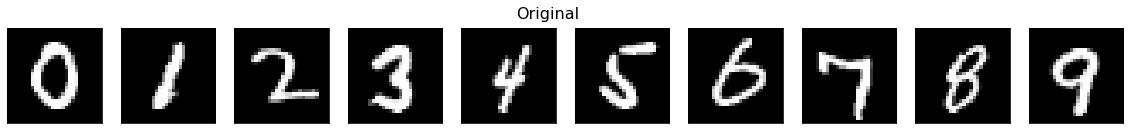

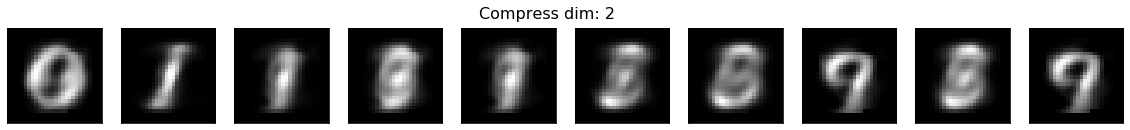

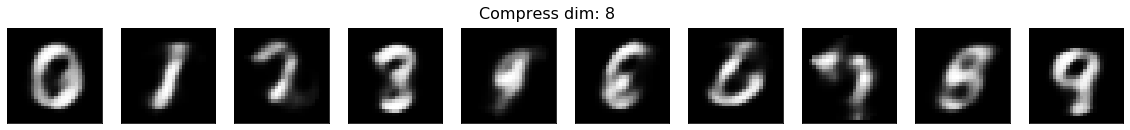

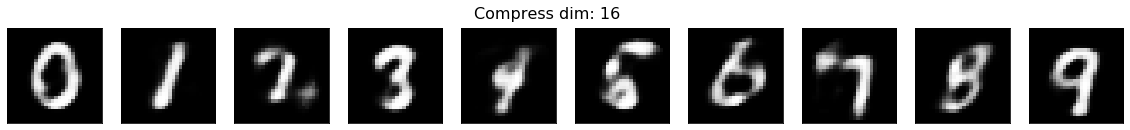

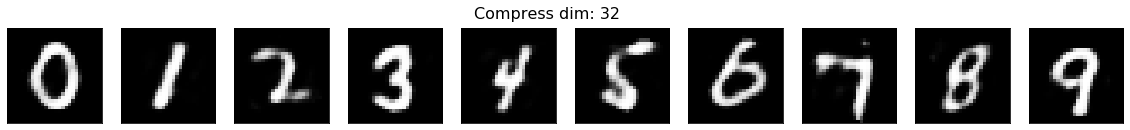

In [0]:
l_ix = [np.random.choice(np.where(y_test == k)[0]) for k in range(10)]
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
fig.suptitle('Original', fontsize=16)
for i, k in enumerate(l_ix):
  axes[i].imshow(x_test[k].reshape(28, 28),cmap='gray')
  axes[i].get_xaxis().set_visible(False)
  axes[i].get_yaxis().set_visible(False)

l_dims = [2, 8, 16, 32]
for compres_dim in l_dims:
  autoencoder = load_model(fdir+'basic_autoencoder_{}.h5'.format(compres_dim))
  decoded_test = autoencoder.predict(x_test)
  fig, axes = plt.subplots(1, 10, figsize=(20, 2))
  fig.suptitle('Compress dim: {}'.format(compres_dim), fontsize=16)
  for i, k in enumerate(l_ix):
    axes[i].imshow(decoded_test[k].reshape(28, 28), cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

## c) Comparación con PCA

Se observa que para todos los casos $d' \in \{2, 8, 16, 32\}$ PCA tiene levemente un mejor _accuracy_, sin embargo, las diferencias de _accuracy_ entre PCA y el encoder son muy bajas. Rondando entre $0.0035$ a  $0.0046$ puntos de diferencia. Además, si se compara la mejora en _accuracy_ del encoder y de PCA a medida que se aumenta $d'$, se tiene que PCA mejora levemente más que el encoder. Considerando que un encoder se puede considerar como una versión generalizada de PCA, se podría esperar que tuviera mejor desempeño. Sin embargo, hay que considerar que el encoder que se está usando en este ejercicio es súper básico ya que cuenta con solo una capa densa.

Ahora, estudiando los tiempos de ejecución, se tiene que PCA es más rápido que el encoder, especialmente en el entrenamiento donde PCA en cien veces más rápido. Entrenar un modelo con PCA  toma entre 1 segundo a casi 3 segundos según el valor de $d'$, mientras que el entrenamiento del autoencoder tomó entre 185 a 193 segundos. En cuanto a la reducción del input a su representación en $\mathbb{R}^{d'}$, PCA es más rápido para los valores bajos de $d'$ tomando entre 1.2 a 2.3 segundos en realizar la operación mientras el encoder demora 3 segundos, para $d'$ PCA demora 2.8 segundos y el encoder 3 segundos. También es posible notar que para dimensiones grandes, el clasificador _kNN_ demora más tiempo en ejecutarse usando la representación del encoder.


In [34]:
n_attr = np.prod(original_img_size)
l_dims = [2, 8, 16, 32]
for compres_dim in l_dims:
  print("Reduction dim [d']: {}".format(compres_dim))
  # Reduccion PCA
  pca = PCA(n_components=compres_dim)
  tt_pca_fit = time.time()
  pca.fit(x_train.reshape(x_train.shape[0],n_attr))
  tt_pca_fit = time.time() - tt_pca_fit
  tt_pca_redux = time.time()
  pca_train = pca.transform(x_train.reshape(x_train.shape[0],n_attr))
  pca_test = pca.transform(x_test.reshape(x_test.shape[0],n_attr))
  tt_pca_redux = time.time() - tt_pca_redux
  # Reduccion encoder
  encoder = load_model(fdir+'basic_encoder_{}.h5'.format(compres_dim))
  tt_enc_redux = time.time()
  encoded_train = encoder.predict(x_train)
  encoded_test = encoder.predict(x_test)
  tt_enc_redux = time.time() - tt_enc_redux
  # Clasificacion
  clf = KNeighborsClassifier(10)
  tt_pca_knn = time.time()
  clf.fit(pca_train, y_train)
  tt_pca_knn = time.time() - tt_pca_knn
  tt_pca_sco = time.time()
  pca_score = clf.score(pca_test,y_test)
  tt_pca_sco = time.time() - tt_pca_sco
  print("> Classification w/ PCA")
  print("          Accuracy: {}".format(pca_score))
  print("    PCA fit (time): {:.3f}[s]".format(tt_pca_fit))
  print("  PCA redux (time): {:.3f}[s]".format(tt_pca_redux))
  print("    KNN fit (time): {:.3f}[s]".format(tt_pca_knn))
  print("       Eval (time): {:.3f}[s]".format(tt_pca_sco))
  clf = KNeighborsClassifier(10)
  tt_enc_knn = time.time()
  clf.fit(encoded_train, y_train)
  tt_enc_knn = time.time() - tt_enc_knn
  tt_enc_sco = time.time()
  enc_score = clf.score(encoded_test,y_test)
  tt_enc_sco = time.time() - tt_enc_sco
  print("> Classification w/ Encoder")
  print("          Accuracy: {}".format(enc_score))
  print("  Enc redux (time): {:.3f}[s]".format(tt_enc_redux))
  print("    KNN fit (time): {:.3f}[s]".format(tt_enc_knn))
  print("       Eval (time): {:.3f}[s]".format(tt_enc_sco))
  print("Diff acc. PCA - Encoder: {:.5f}".format(pca_score-enc_score))
  print()

Reduction dim [d']: 2
> Classification w/ PCA
          Accuracy: 0.4427
    PCA fit (time): 1.311[s]
  PCA redux (time): 0.186[s]
    KNN fit (time): 0.034[s]
       Eval (time): 0.323[s]
> Classification w/ Encoder
          Accuracy: 0.4392
  Enc redux (time): 3.036[s]
    KNN fit (time): 0.034[s]
       Eval (time): 0.321[s]
Diff acc. PCA - Encoder: 0.00350

Reduction dim [d']: 8
> Classification w/ PCA
          Accuracy: 0.9029
    PCA fit (time): 1.979[s]
  PCA redux (time): 0.215[s]
    KNN fit (time): 0.043[s]
       Eval (time): 1.266[s]
> Classification w/ Encoder
          Accuracy: 0.8992
  Enc redux (time): 3.034[s]
    KNN fit (time): 0.044[s]
       Eval (time): 1.170[s]
Diff acc. PCA - Encoder: 0.00370

Reduction dim [d']: 16
> Classification w/ PCA
          Accuracy: 0.9612
    PCA fit (time): 2.286[s]
  PCA redux (time): 0.236[s]
    KNN fit (time): 0.070[s]
       Eval (time): 5.840[s]
> Classification w/ Encoder
          Accuracy: 0.9567
  Enc redux (time): 3.017

## d) _Deep convolutional autoencoder_

A continuación con dos capas convolucionales y _maxpooling_ en el encoder y dos capas convolucionales y _UpSampling_ en el decoder.

En el encoder, el input entra con dimensiones `(28 x 28 x 1)` y pasa por una capa convolucional de `16` filtros y kernel `3x3`, con `padding='same'` por lo que mantiene el tamaño del input. Esta capa tiene $9*16+16=160$ parámetros y el _output_ tiene tamaño `(28 x 28 x 16)`. Luego se pasa por una capa `MaxPooling2D` de kernel `2x2` que da una matriz de tamaño `(14 x 14 x 16)`. Luego, se pasa por otra capa convolucional de `32` filtros, kernel `3x3` y `padding='same'` lo que da $9*16*32 + 32 = 4640$ parámetros entrenables y _output_ `(14 x 14 x 32)`. Luego, se pasa por un `MaxPooling` obteniendo una matriz de tamaño `(7 x 7 x 32)`.  Esta matriz se transforma a un vector unidimensional de tamaño `1568` y se pasa por una capa densa de `<compres_dim> = {2, 8, 16, 32}` neuronas. El output de esta capa es la representación codificada del input.

El decoder es simétrico al encoder, pero inverso en el sentido de aumentar el tamaño del input. Primero, se pasa el input (vector unidimensional de tamaño `<compres_dim>`) por una capa densa con `1568` neuronas, el _output_ es transformado a un vector de tres dimensiones con tamaño `(7 x 7 x 32)`. Luego se pasa por una capa convolucional que mentiene su tamaño usando _padding_ y que tiene `32` filtros y kernel de `3x3`, al output de esta capa se pasa por un `UpSampling` de tamaño `2x2` que deja la matriz de _output_ con tamaño `(14 x 14 x 32)`. Se repite este proceso con una capa convolucional de `16` filtros, kernel `3x3` y un `UpSampling` de `2x2`, obteniendo una matriz de tamaño `(28 x 28 x 16)`. Finalmente se usa una capa convolucional, de `1` filtro, kernel `3x3`, `padding='same'` y activación sigmoidal para obtener la reconstrucción del input a partir del vector de representación dado por el encoder.

De los resultados del entrenamiento se observa que este AE convolucional tiene mejores resultados, en cuanto a los resultados de la _loss_, que el AE básico para todos los valores de $d'$. Sin embargo, la red demora un poco más del doble de tiempo en entrenar que el AE básico.

En comparación con PCA, el AE convolucional tiene mejores resultados para todos los valores de $d'$. Para los valores más bajos del tamaño de representación $d'$, el AE convolucional es donde tiene mayor diferencia. Sin embargo, a medida que se aumenta $d'$, PCA se acerca más al desempeño del AE convolucional pero sin pasarlo. Para $d' = 32$, la diferencia de puntaje entre ambos métodos es sólo $0.0037$ puntos, mientras que para $d' = 2$ la diferencia es de $0.2109$ puntos.

En cuanto a los tiempos de ejecución PCA es mucho más rápido, como ya se vió con el AE básico. Mientras PCA demora entre 1.7 y 3 segundos en entrenar, el AE convolucional tarda algo más de 7 minutos. Para reducir el input al vector de representación, PCA vuelve a ser más rápido tardando cerca de 0.2 segundos mientras que el AE tarda un poco más de 4 segundos en realizar la reducción para la misma cantidad de input (set de entrenamiento + testing). En relación al clasificador _kNN_, los tiempos de ejecución son similares usando cualquiera de los métodos. Al contrario de lo que ocurrió con el AE básico, donde el clasificador parecia beneficiarce de la representación dada por PCA al ejecutarse más rápido.

In [0]:
l_dims = [2, 8, 16, 32]
for compres_dim in l_dims:
  input_img = Input(shape=original_img_size)
  # Encoder
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2))(x)
  before_F_shape =  (x.shape[1].value, x.shape[2].value, x.shape[3].value)
  x = Flatten()(x)
  encoded = Dense(compres_dim, activation='relu')(x)
  # Decoder
  x = Dense(np.prod(before_F_shape),activation='relu')(encoded)
  x = Reshape(before_F_shape)(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  # Models
  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)
  # Training
  autoencoder.compile(optimizer='rmsprop', loss='msle')
  time_callback = TimeHistory()
  hist = autoencoder.fit(x_train, x_train, epochs=40, batch_size=32, validation_data=(x_test,x_test), callbacks=[time_callback], verbose=False)
  # Save & stats
  autoencoder.save(fdir+'deep_autoencoder_{}.h5'.format(compres_dim))
  encoder.save(fdir+'deep_encoder_{}.h5'.format(compres_dim))
  print("  Compression d': {}".format(compres_dim))
  print("      Train loss: {}".format(hist.history['loss'][-1]))
  print("        Val loss: {}".format(hist.history['val_loss'][-1]))
  print("  Train time [s]: {}".format(sum(time_callback.times)))
  print("Time x epoch [s]: {}".format(np.average(time_callback.times)))
  print()

  Compression d': 2
       Test loss: 0.020299501570065815
        Val loss: 0.02034508204460144
  Train time [s]: 433.9601848125458
Time x epoch [s]: 10.849004620313645

  Compression d': 8
       Test loss: 0.0077361083013316
        Val loss: 0.008156497015058994
  Train time [s]: 431.8214225769043
Time x epoch [s]: 10.795535564422607

  Compression d': 16
       Test loss: 0.003728743668521444
        Val loss: 0.003971640203148127
  Train time [s]: 434.1502559185028
Time x epoch [s]: 10.85375639796257

  Compression d': 32
       Test loss: 0.002173778142593801
        Val loss: 0.002121732173115015
  Train time [s]: 436.8650813102722
Time x epoch [s]: 10.921627032756806



**Comparación con PCA**

In [36]:
n_attr = np.prod(original_img_size)
l_dims = [2, 8, 16, 32]
for compres_dim in l_dims:
  print("Reduction dim [d']: {}".format(compres_dim))
  # Reduccion PCA
  pca = PCA(n_components=compres_dim)
  tt_pca_fit = time.time()
  pca.fit(x_train.reshape(x_train.shape[0],n_attr))
  tt_pca_fit = time.time() - tt_pca_fit
  tt_pca_redux = time.time()
  pca_train = pca.transform(x_train.reshape(x_train.shape[0],n_attr))
  pca_test = pca.transform(x_test.reshape(x_test.shape[0],n_attr))
  tt_pca_redux = time.time() - tt_pca_redux
  # Reduccion encoder
  encoder = load_model(fdir+'deep_encoder_{}.h5'.format(compres_dim))
  tt_enc_redux = time.time()
  encoded_train = encoder.predict(x_train)
  encoded_test = encoder.predict(x_test)
  tt_enc_redux = time.time() - tt_enc_redux
  # Clasificacion
  clf = KNeighborsClassifier(10)
  tt_pca_knn = time.time()
  clf.fit(pca_train, y_train)
  tt_pca_knn = time.time() - tt_pca_knn
  tt_pca_sco = time.time()
  pca_score = clf.score(pca_test,y_test)
  tt_pca_sco = time.time() - tt_pca_sco
  print("> Classification w/ PCA")
  print("          Accuracy: {}".format(pca_score))
  print("    PCA fit (time): {:.3f}[s]".format(tt_pca_fit))
  print("  PCA redux (time): {:.3f}[s]".format(tt_pca_redux))
  print("    KNN fit (time): {:.3f}[s]".format(tt_pca_knn))
  print("       Eval (time): {:.3f}[s]".format(tt_pca_sco))
  clf = KNeighborsClassifier(10)
  tt_enc_knn = time.time()
  clf.fit(encoded_train, y_train)
  tt_enc_knn = time.time() - tt_enc_knn
  tt_enc_sco = time.time()
  enc_score = clf.score(encoded_test,y_test)
  tt_enc_sco = time.time() - tt_enc_sco
  print("> Classification w/ Encoder")
  print("          Accuracy: {}".format(enc_score))
  print("  Enc redux (time): {:.3f}[s]".format(tt_enc_redux))
  print("    KNN fit (time): {:.3f}[s]".format(tt_enc_knn))
  print("       Eval (time): {:.3f}[s]".format(tt_enc_sco))
  print("Diff acc. PCA - Encoder: {:.5f}".format(pca_score-enc_score))
  print()

Reduction dim [d']: 2
> Classification w/ PCA
          Accuracy: 0.4426
    PCA fit (time): 1.721[s]
  PCA redux (time): 0.262[s]
    KNN fit (time): 0.033[s]
       Eval (time): 0.330[s]
> Classification w/ Encoder
          Accuracy: 0.6535
  Enc redux (time): 4.217[s]
    KNN fit (time): 0.033[s]
       Eval (time): 0.312[s]
Diff acc. PCA - Encoder: -0.21090

Reduction dim [d']: 8
> Classification w/ PCA
          Accuracy: 0.9029
    PCA fit (time): 1.987[s]
  PCA redux (time): 0.222[s]
    KNN fit (time): 0.044[s]
       Eval (time): 1.249[s]
> Classification w/ Encoder
          Accuracy: 0.9479
  Enc redux (time): 4.276[s]
    KNN fit (time): 0.043[s]
       Eval (time): 1.248[s]
Diff acc. PCA - Encoder: -0.04500

Reduction dim [d']: 16
> Classification w/ PCA
          Accuracy: 0.9613
    PCA fit (time): 2.348[s]
  PCA redux (time): 0.227[s]
    KNN fit (time): 0.070[s]
       Eval (time): 5.891[s]
> Classification w/ Encoder
          Accuracy: 0.9724
  Enc redux (time): 4.2

## e) Visualización con TSNE

A continuación se visualizan las represntaciones de los inputs hechas por el encoder convolucional y por PCA con d' = 32, para esto se reducen las dimensiones a sólo 2 usando t-SNE. El primer gráfico corresponde a la representación generada por el encoder convolucional. Se puede observar la separación de cada cluster que representa un digito, aunque se notan dos grupos donde los clusters están muy cerca entre sí. Los dígitos $4$ y $9$ (representados por '>' morado  y 'x' marron) se observan muy cercanos entre sí y con algunos datos mezclados, estos son justamente un par de dígitos considerados como fáciles de confundir entre sí por los modelos al explorar los datos en el inicio de esta pregunta. Otro grupo de dígitos cercanos entre sí son $3$, $5$ y $8$ (representados por 3: '<' cyan; 5: '^' yellow; 8: ''\*'' darkgreen), que también fue un grupo anticipado como fácil de ser confundido.

Con respecto a PCA, todos los grupos están juntos en un gran cluster pero se pueden observar "zonas" en donde se concentran más ejemplos de un digito en particular. Aunque se ven los grupos bastante mezclados, hay que tener presente que el clasificador _kNN_ usando las representaciones de PCA con 32 componentes, obtuvo un _accuracy_ muy similar al del encoder convolucional con $d' = 32$.

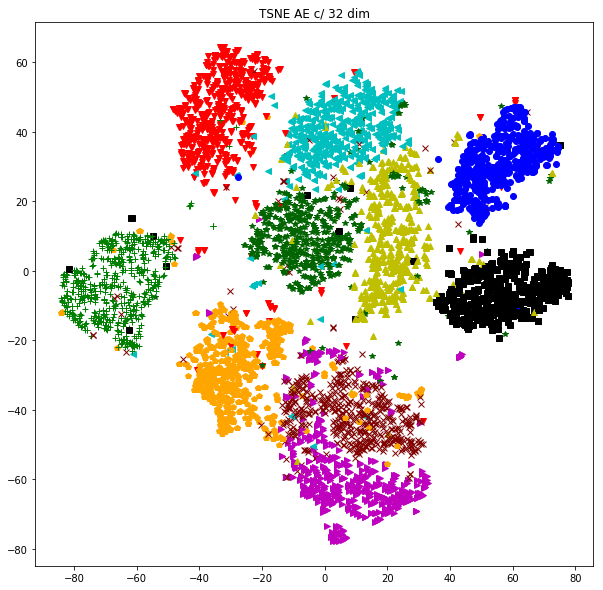

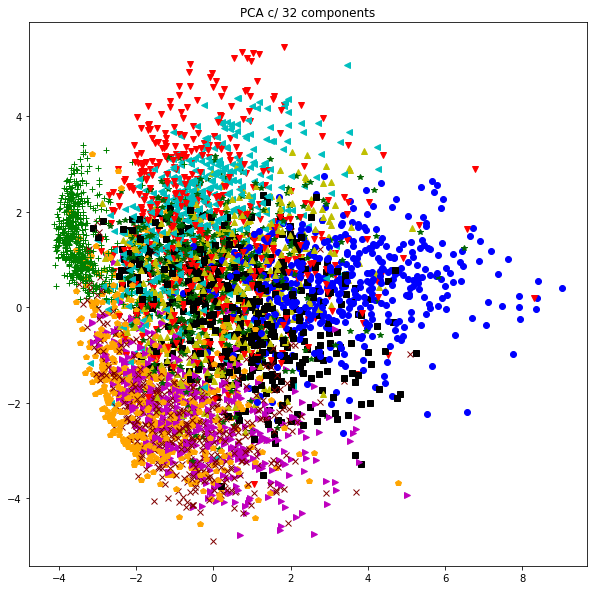

In [0]:
nplot=5000 #warning: mind your memory!
compres_dim = 32
encoder = load_model(fdir+'deep_encoder_{}.h5'.format(compres_dim))
encoded_test = encoder.predict(x_test[:nplot])

model = TSNE(n_components=2, random_state=0)
encoded_test = model.fit_transform(encoded_test)

plt.figure(figsize=(10, 10))
plt.title("TSNE AE c/ {} dim".format(compres_dim))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
  label = y_test[idx]
  line = plt.plot(encoded_test[idx][0], encoded_test[idx][1],
                  color=colors[label], marker=markers[label], markersize=6)

n_attr = np.prod(original_img_size)
pca = PCA(n_components=compres_dim)
pca.fit(x_test.reshape(x_test.shape[0],n_attr))
pca_test = pca.transform(x_test.reshape(x_test.shape[0],n_attr))
encoded_test = pca_test[:nplot]
plt.figure(figsize=(10, 10))
plt.title("PCA c/ {} components".format(compres_dim))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
  label = y_test[idx]
  line = plt.plot(encoded_test[idx][0], encoded_test[idx][1],
                  color=colors[label], marker=markers[label], markersize=6)

# 4.2 _Variational Autoencoder_ tradicional

## a) Encoder

El encoder consta de tres capas convolucionales. La primera capa se tiene 32 filtros y kernel de 3x3 con _padding_ que conserva las primeras dos dimensiones del input. La entrada tiene un tamaño de `(28 x 28 x 1)` y la salida,`(28 x 28 x 32)` . Dado el tamaño del kernel, los canales de entrada y de salida se tienen $9 * 32 + 32 = 320$ parámetros en esta capa. La capa siguiente también tiene 32 filtros, kernel de 3 x 3 y `padding = 'same'`, por lo que se tienen, $9 *32*32 + 32 = 9.248$ parámetros. La tercera capa convolucional tiene 64 filtros, kernel de 3 x 3 y `stride = 2`, lo que divide por la mitad las primeras dos dimensiones y la salida tiene un tamaño de `(14 x 14 x 64)`. Esta capa tiene $9*32*64 +64=18.496$ parámetros entrenables.

Luego, el cubo de salida se convierte a un vector unidimensional de tamaño `18.496` y se usa de input para la capa densa intermedia de 128 neuronas. Esta capa tienee $ 18496*128 + 128 =1605760$ parámetros. 

Finalmente, se tienen las dos capas densas en paralelo que representan las variables latentes de la distribución que define los datos. Estas últimas dos capas tienen 2 neuronas cada una y ambas reciben de _input_ la salida de la capa densa de 128 neuronas. 

In [22]:
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 2
# Encoder
x = Input(shape=original_img_size, name="input_vae")
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_1")(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_2")(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2, name="conv_3")(conv_2)
flat = Flatten(name="flat_enco")(conv_3)
hidden = Dense(intermediate_dim, activation='relu', name="inter_enco")(flat)
z_mean = Dense(latent_dim,activation='linear', name="z_mean")(hidden)
z_log_var = Dense(latent_dim,activation='linear', name="z_log_var")(hidden)
encoder = Model(x, [z_mean, z_log_var])# build a model to project inputs on the latent space

encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_vae (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 28, 28, 32)   320         input_vae[0][0]                  
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 28, 28, 32)   9248        conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 14, 14, 64)   18496       conv_2[0][0]                     
__________________________________________________________________________________________________
flat_enco 

## b) Decoder

Ahora, se hace el proceso inverso al del _encoder_. 


Primero, el vector de entrada (unidimensional de tamaño 2) se lleva a una representación intermedia pasandolo por una capa densa de 128 neuronas, que tiene $2*128 + 128 = 384$ parámetros. Luego, se hace un _up-sampling_ con una capa densa de $14*14*64 = 12.544$ neuronas. El vector se transforma en una matriz tri-dimensional de tamaño `(14 x 14 x 64)` que se pasará por tres capas convolucionales transpuestas para generar finalmente la salida de la red con tamaño `(28 x 28 x 1)` como las imagenes de entrada de 28 x 28 pixeles con un canal.

Una capa de convolución transpuesta realiza una operación normal de convolución en su _input_, pero puede hacer también una forma de _up-sampling_ al usar `stride`. Antes de realizar la convolución, se intercalan ceros entre los datos de entrada según lo indicado en el parámetro `stride`, esto aumenta la cantidad de datos en los que hace efectivamente la convolución, lo que hace que el _output_ de la capa sea de mayor tamaño que el input que recibió.

In [0]:
shape_before_flattening = K.int_shape(conv_3)[1:] # we instantiate these layers separately to reuse them later

decoder_hid = Dense(intermediate_dim, activation='relu', name="inter_deco")
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu', name="upsampling")
decoder_reshape = Reshape(shape_before_flattening, name="reshape_deco")
decoder_deconv_1 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=2, activation='relu', name="convT_1")
decoder_deconv_2 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', activation='relu', name="convT_2")
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv, padding='same', activation='sigmoid', name="convT_3")

## c) Sampling

Ya que las capas densas `z_mean` y `z_log_var` ($\mu$ y $\ln\sigma$ respectivamente) son deterministas, se necesita hacer un muestreo de la distribución normal $\epsilon \sim \mathcal{N}(0,1)$ y calcular el input del decoder  $z = \mu + \sigma \cdot \epsilon$. Conectando de esta forma el _output_ del encoder con el _input_ del decoder se introduce la propiedad probabilistica de un autoencoder variacional. 

La función definida a continuación hace un muestreo de la distribución normal estandar y realiza la operación $z = \mu + \exp{\ln{\sigma}} \cdot \epsilon = \mu + \sigma \cdot \epsilon$, para retornar el resultado como _input_ al encoder. A continuación,  en lo que sigue del código, se define una capa _lambda_ que ejecuta la función de _sampling_ y que sirve como capa para conectar el encoder y decoder. Luego, se termina de definir el decoder conectando las capas a través de sus _outputs_ e _intputs_. Finalmente se muestra un sumario del VAE mostrando los _outputs_ y parámetros descritos en las secciones anteriores.

In [0]:
def make_sampling(latent_dim):
  def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
  return sampling

In [25]:
z = Lambda(make_sampling(latent_dim), output_shape=(latent_dim,), name="sampling")([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_encoder = Model(x, z)

vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_vae (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 28, 28, 32)   320         input_vae[0][0]                  
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 28, 28, 32)   9248        conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 14, 14, 64)   18496       conv_2[0][0]                     
__________________________________________________________________________________________________
flat_enco 

## d) Función _Loss_

Para este modelo se escoge la función de pérdida `logcosh` para evaluar la reconstrucción. Como se menciona en (a) de la sección anterior, esta función fue la que mejor desempeño tuvo (en cuanto a _training loss_ y _validation loss_) para dimensiones de representación bajas.

Como regularizador se usa KL divergence, que mide la diferencia o distancia entre dos distribuciones de probabilidad. Se usa como regularizador en la _loss_ del modelo para que  el encoder $q_{\phi}(z\mid x)$ aproxime la función real $p_{\theta}(z)$ que debería usar el encoder del modelo. Como ambas distribuciones son normales, se tiene que: 

$$KL( q_{\phi}(z\mid x) \mid \mid p_{\theta}(z)) = \ln{\frac{\sigma_2}{\sigma_1}} + \frac{\sigma_1^2 +(\mu_1 -\mu_2)^2}{2\sigma_2^2}- \frac{1}{2}$$

$p_{\theta}(z)$ se escoge como la función normal estandar, por lo que $\mu_2 = 0$ y $\sigma_2 = 1$:

$$KL( q_{\phi}(z\mid x) \mid \mid p_{\theta}(z)) = -\frac{1}{2}[\ln{\sigma_1} - \sigma_1^2 - \mu_1^2 +1] $$

que es la expresión que se usa como regularizador en la _loss_ del modelo.

In [26]:
#choised_loss = binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss = logcosh(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #closed form
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_norm.add_loss(vae_loss)

vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_vae (InputLayer)          (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 28, 28, 32)   320         input_vae[0][0]                  
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 28, 28, 32)   9248        conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 14, 14, 64)   18496       conv_2[0][0]                     
__________________________________________________________________________________________________
flat_enco 

## e) Entrenamiento

Se realiza el entrenamiento con batch de tamaño `128` y `30` epochs.

In [27]:
batch_size = 128
epochs =  30

vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 21s 351us/step - loss: 168.3822 - val_loss: 21.3171
Epoch 2/30
60000/60000 [==============================] - 20s 330us/step - loss: 20.3561 - val_loss: 19.8462
Epoch 3/30
60000/60000 [==============================] - 20s 332us/step - loss: 19.3222 - val_loss: 19.2213
Epoch 4/30
60000/60000 [==============================] - 20s 329us/step - loss: 18.7053 - val_loss: 18.4196
Epoch 5/30
60000/60000 [==============================] - 20s 327us/step - loss: 18.3088 - val_loss: 18.2631
Epoch 6/30
60000/60000 [==============================] - 20s 331us/step - loss: 18.0381 - val_loss: 18.0244
Epoch 7/30
60000/60000 [==============================] - 20s 330us/step - loss: 17.8411 - val_loss: 18.0291
Epoch 8/30
60000/60000 [==============================] - 20s 330us/step - loss: 17.6709 - val_loss: 17.7237
Epoch 9/30
60000/60000 [==============================] - 20s 332us/step - lo

## f) Visualización espacio latente e histograma variables

En el primer gráfico se visualiza la representación en las dos variables latentes que el encoder da al _input_. En el eje `x` varía $z_0$ y en el eje `y`, $z_1$. La clase de cada digito está representada por un color y se puede observar en el gráfico las "zonas" en el espacio latente en el que se concentran los ejemplos de cada clase. Una caracteristica importante, es que todas las clases estan juntas y se aprecia una transición entre una clase y otra más o menos gradual. Esto es conveniente al generar datos nuevos, ya que da un rango de movilidad en las variables latentes.

En el gráfico, se puede notar que los ejemplos para el digito $6$ parecen agruparse en dos _clusters_ separados entre sí. También, se puede observar que algunas clases están un poco más mezcladas entre sí, como por ejemplo, lo forman digitos $4$ y $9$ y el grupo de dígitos $3$, $5$ y $8$. Esto es muy similar a lo que se observó en la representación del autoencoder convolucional visualizado con tSNE, donde estos mismos grupos se destacaron por estar más mezclados.

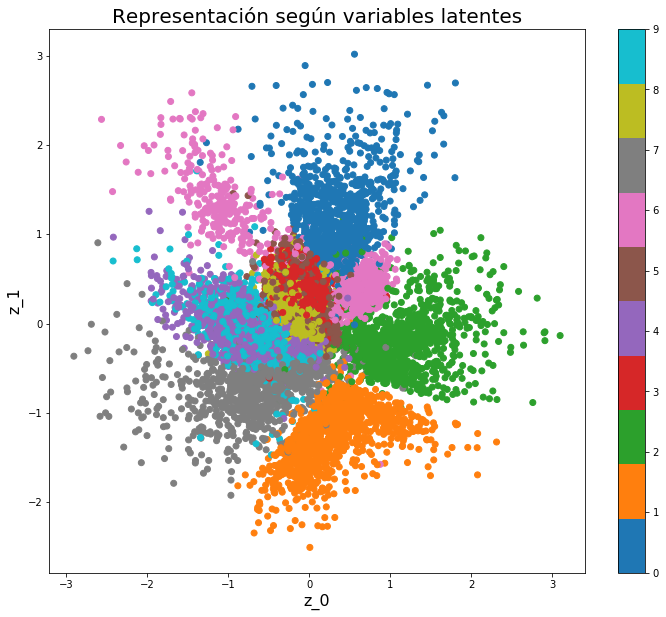

In [48]:
x_test_encoded = np.array(vae_encoder.predict(x_test, batch_size=batch_size))

plt.figure(figsize=(12, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.title("Representación según variables latentes", fontsize=20)
plt.xlabel("z_0", fontsize=16)
plt.ylabel("z_1", fontsize=16)
plt.show()

**Histograma variables latentes**

Los primeros dos histogramas, muestran la distribución de los parámetros $\mu_0$ y $\mu_1$ generados en la capa densa `z_mean` del encoder. En ambos casos se puede ver que los datos están centrados en $0$, la mayoría en el intervalo $[-1,1]$.

Los siguientes dos histogramas corresponden a los parámetros $\sigma_0^2$ y $\sigma_1^2$ representados en la capa densa `z_log_var` en el encoder. Se observa que los datos son muy cercanos a $0$ y la gran mayoría con valores menores a $0.2$.

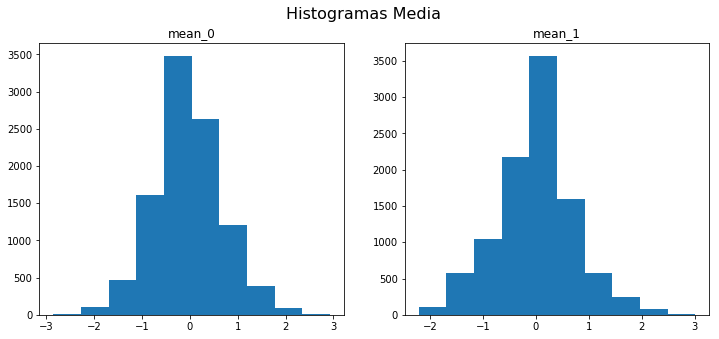

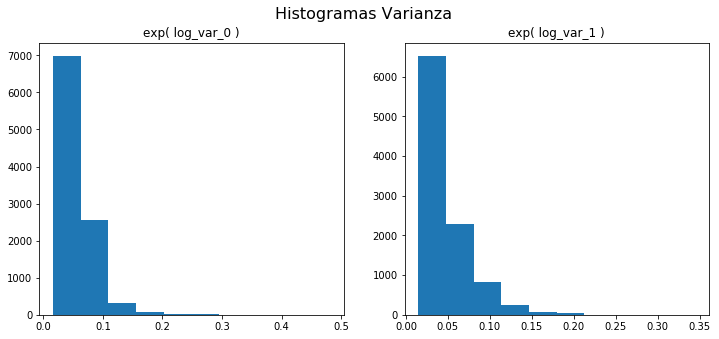

In [45]:
latents_test = encoder.predict(x_test, batch_size=batch_size)

# Histograma z_mean
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Histogramas Media', fontsize=16)
axes[0].hist(latents_test[0][:,0])
axes[1].hist(latents_test[0][:,1])
axes[0].set_title("mean_0")
axes[1].set_title("mean_1")
plt.show()

# Histograma z_log_var
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Histogramas Varianza', fontsize=16)
axes[0].hist(np.exp(latents_test[1][:,0]))
axes[1].hist(np.exp(latents_test[1][:,1]))
axes[0].set_title("exp( log_var_0 )")
axes[1].set_title("exp( log_var_1 )")
plt.show()

## g) Datos generados con el decoder

El siguiente gráfico se genera tomando los valores de las variables latentes $z_0$ y $z_1$ dentro del $90\%$ del rango de confianza de la distribución normal. El eje x corresponde a $z_0$ y el eje y corresponde a $z_1$. En las imágenes generadas, se puede apreciar claramente la transición entre los distintos dígitos a medida que se mueve entre los valores de las variables latentes. Al igual que en el primer gráfico de la sección (f), se encuentran dos zonas en el que se generan imágenes similares al digito $6$. Los digitos $8$, $5$ y $3$ se encuentran en el centro del gráfico.

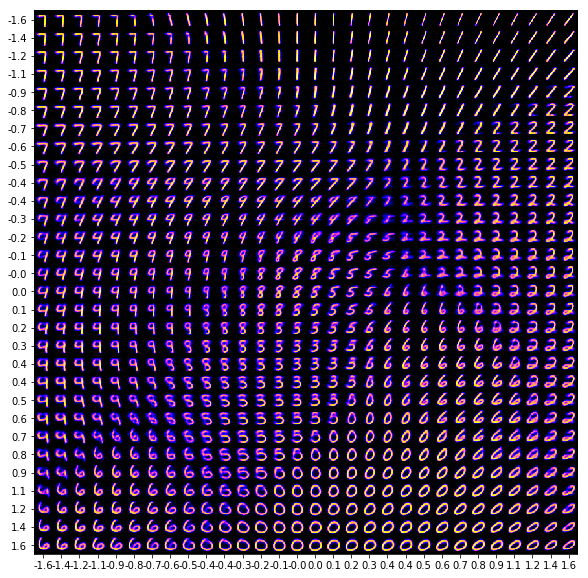

In [46]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

n = 30  # figure with 15x15 images 
image_size = img_cols # 28
figure = np.zeros((image_size * n, image_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) #metodo de la transformada inversa
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
# Plot
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()


En los siguientes gráficos se observan los extremos de las variables latentes fuera del rango de $90\%$ de confianza.

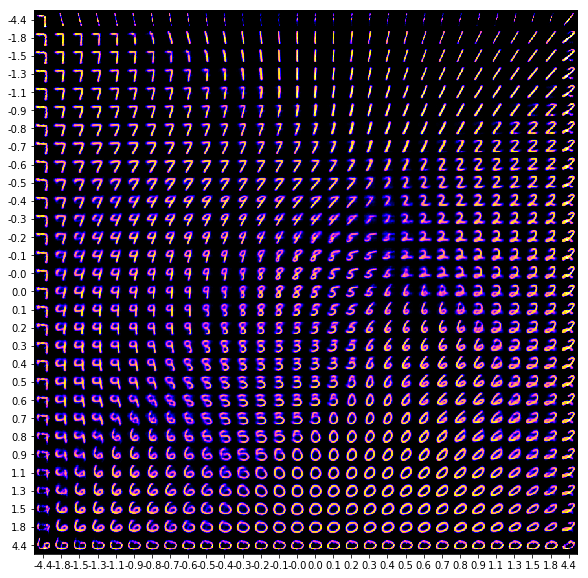

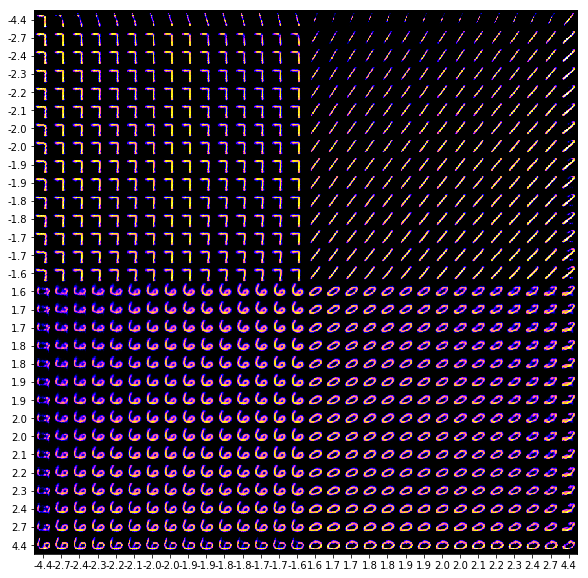

In [47]:
grid_x = norm.ppf(np.linspace(0.000005, 0.999995, n))
grid_y = norm.ppf(np.linspace(0.000005, 0.999995, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
# Plot
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()


#grid = norm.ppf(np.linspace(0.000005, 0.999995, n)) #en los extremos del intervalo de confianza
#grid_x = norm.ppf(np.linspace(0.000005, 0.999995, n))
#grid_y = norm.ppf(np.linspace(0.000005, 0.999995, n))
grid_x = np.concatenate((norm.ppf(np.linspace(0.000005, 0.05, int(n/2))), norm.ppf(np.linspace(0.95, 0.999995, int(n/2)))))
grid_y = np.concatenate((norm.ppf(np.linspace(0.000005, 0.05, int(n/2))), norm.ppf(np.linspace(0.95, 0.999995, int(n/2)))))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
# Plot
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()

## h) Desempeño como clasificador.

A continuación se prueba la calidad como clasificador del VAE para distintos tamaños de representación de las variables latentes, $d' = [2, 8, 16, 32]$. Se usan como métricas, el _accuracy_ que logra el clasificador _kNN_ usando la representación generada por el encoder, la _loss_ de entrenamiento y validación del modelo.

Para $d'=2$, se tiene que el _accuracy_ logrado por el clasificador _kNN_ es mejor que la que alcanzó usando PCA o el AE convolucional (kNN+PCA: $0.4426$; kNN+AE_conv: $0.6535$; kNN+VAE: $0.75740$). La _loss_ del VAE, por otro lado, es bastante más alta que la del autoencoder convolucional, pero, dado los resultados anteriores esto no parece ser un buen indicador de la calidad como clasificador.

Para $d'=8$, se logra un mejor _accuracy_ con el clasificador, sin embargo, el puntaje es menor al obtenido al usar la representación generada por el autoencoder convolucional.

Para $d'=16$ y $d'=32$ la _accuracy_ del clasificador _kNN_ disminuye a $0.8$ y $0.5$ respectivamente, empeorando el desempeño y quedando por debajo de PCA y el AE convolucional.

In [0]:
import time
from keras.callbacks import Callback

class TimeHistory(Callback):
  def on_train_begin(self, logs=None):
    self.times = []

  def on_epoch_begin(self, epoch, logs=None):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs=None):
    self.times.append(time.time() - self.epoch_time_start)

  def on_predict_begin(self, logs=None):
    self.predict_time = time.time()

  def on_predict_end(self, logs=None):
    self.predict_time = time.time() - self.predict_time

In [55]:
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128

l_dims = [2, 8, 16, 32]
for latent_dim in l_dims:
  # Encoder
  x = Input(shape=original_img_size, name="input_vae")
  conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_1")(x)
  conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_2")(conv_1)
  conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2, name="conv_3")(conv_2)
  flat = Flatten(name="flat_enco")(conv_3)
  hidden = Dense(intermediate_dim, activation='relu', name="inter_enco")(flat)
  z_mean = Dense(latent_dim,activation='linear', name="z_mean")(hidden)
  z_log_var = Dense(latent_dim,activation='linear', name="z_log_var")(hidden)
  # Decoder
  z = Lambda(make_sampling(latent_dim), output_shape=(latent_dim,), name="sampling")([z_mean, z_log_var])
  hid_decoded = Dense(intermediate_dim, activation='relu', name="inter_deco")(z)
  up_decoded = Dense(np.prod(K.int_shape(conv_3)[1:]), activation='relu', name="upsampling")(hid_decoded)
  reshape_decoded =  Reshape(K.int_shape(conv_3)[1:], name="reshape_deco")(up_decoded)
  deconv_1_decoded = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=2, activation='relu', name="convT_1")(reshape_decoded)
  x_decoded_relu = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', activation='relu', name="convT_2")(deconv_1_decoded)
  x_decoded_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv, padding='same', activation='sigmoid', name="convT_3")(x_decoded_relu)
  # Modelos
  vae_norm = Model(x, x_decoded_mean_squash)
  vae_encoder = Model(x, z)
  # Loss
  reconstruction_loss = img_rows * img_cols * channel* logcosh(K.flatten(x),K.flatten(x_decoded_mean_squash))
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #closed form
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  vae_norm.add_loss(vae_loss)
  # Train
  batch_size = 128
  epochs =  30
  vae_norm.compile(optimizer='rmsprop')
  time_callback = TimeHistory()
  hist = vae_norm.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None), callbacks=[time_callback], verbose=False)
  # Stats
  encoded_train = vae_encoder.predict(x_train)
  encoded_test = vae_encoder.predict(x_test)
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  enc_score = clf.score(encoded_test,y_test)
  print(">> Latent vars dim: {}".format(latent_dim))
  print("      kNN Accuracy: {:.5f}".format(enc_score))
  print("        Train loss: {:.5f}".format(hist.history['loss'][-1]))
  print("          Val loss: {:.5f}".format(hist.history['val_loss'][-1]))
  print("       Train time : {:.1f}[s]".format(sum(time_callback.times)))
  print("     Time x epoch : {:.1f}[s]".format(np.average(time_callback.times)))
  print()

>> Latent vars dim: 2
      kNN Accuracy: 0.75740
        Train loss: 16.62938
          Val loss: 17.02724
       Train time : 574.7[s]
     Time x epoch : 19.2[s]

>> Latent vars dim: 8
      kNN Accuracy: 0.91930
        Train loss: 13.03681
          Val loss: 13.14598
       Train time : 576.0[s]
     Time x epoch : 19.2[s]

>> Latent vars dim: 16
      kNN Accuracy: 0.80640
        Train loss: 12.89555
          Val loss: 13.09624
       Train time : 577.3[s]
     Time x epoch : 19.2[s]

>> Latent vars dim: 32
      kNN Accuracy: 0.54540
        Train loss: 13.13305
          Val loss: 13.44127
       Train time : 579.0[s]
     Time x epoch : 19.3[s]



## 4.3 Variational Autoencoder categórico

### a) Definición modelo

Con este modelo se quiere representar una variable categorica por lo que se debe reemplazar las capas densas `z_mean` y `z_log_var` del modelo anterior, por una capa densa (`logits_z`) de $10$ neuronas con activación lineal. También se debe cambiar la capa de _sampling_ que conecta el encoder con el decoder, para esto se define una función que agrega ruido de la función de probabilidad `Gumbel(0, 1)` al output del encoder (la variable categorica `logits_z`) y realiza un softmax sobre el vector resultante, lo que se pasa como _input_ al decoder. Por último, se debe cambiar el término regularizador en la función _loss_ pues ahora se está usando una distribución multinomial para la variable latente y se necesita que el decoder aproxime esta distribución.

**Función _sampling_**

In [0]:
from keras.activations import softmax

def sample_gumbel(shape, eps=K.epsilon()):
  """Inverse Sample function from Gumbel(0, 1)"""
  U = K.random_uniform(shape, 0, 1)
  return - K.log( -K.log(U + eps) + eps)

def sampling(logits_z):
  """ Perform a Gumbel-Softmax sampling"""
  tau = K.variable(2/3, name="temperature")
  z = logits_z + sample_gumbel(K.shape(logits_z)) # logits + gumbel noise
  return softmax( z/tau )

**Modelo**

In [10]:
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 10

# Encoder
x = Input(shape=original_img_size, name="input_vae")
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_1")(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu', name="conv_2")(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2, name="conv_3")(conv_2)
flat = Flatten(name="flat_enco")(conv_3)
hidden = Dense(intermediate_dim, activation='relu', name="inter_enco")(flat)
logits_z = Dense(latent_dim, activation='linear', name="logits_z")(hidden) #log(p(z))
# Decoder Layers
decoder_hid = Dense(intermediate_dim, activation='relu', name="inter_deco")
decoder_upsample = Dense(np.prod(K.int_shape(conv_3)[1:]), activation='relu', name="upsampling")
decoder_reshape = Reshape(K.int_shape(conv_3)[1:])
decoder_deconv_1 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=2, activation='relu', name="convT_1")
decoder_deconv_2 = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', activation='relu', name="convT_2")
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv, padding='same', activation='sigmoid', name="convT_3")
# Decoder
z = Lambda(sampling, output_shape=(latent_dim,), name="cat_sampling")(logits_z)
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# Modelos
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_encoder = Model(x, logits_z)

# Loss
reconstruction_loss = img_rows * img_cols * channel * mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
dist =  softmax(logits_z) # =p(z)
dist_neg_entropy = K.sum(dist * K.log(dist + K.epsilon()), axis=1)
kl_disc_loss =  np.log(latent_dim) + dist_neg_entropy #discrete KL-loss
vae_loss = K.mean(reconstruction_loss + kl_disc_loss)
vae_norm.add_loss(vae_loss)


# Summary
vae_norm.summary()

W0801 20:34:25.878373 139861156054912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_vae (InputLayer)       (None, 28, 28, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 32)        9248      
_________________________________________________________________
conv_3 (Conv2D)              (None, 14, 14, 64)        18496     
_________________________________________________________________
flat_enco (Flatten)          (None, 12544)             0         
_________________________________________________________________
inter_enco (Dense)           (None, 128)               1605760   
_________________________________________________________________
logits_z (Dense)             (None, 10)                1290      
__________

### b) Entrenamiento

Se realiza el entrenamiento usando un tamaño de batch de `128` y con `30` epochs.

In [12]:
batch_size = 128
epochs = 30

vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 20s 335us/step - loss: 41.5968 - val_loss: 39.8939
Epoch 2/30
60000/60000 [==============================] - 19s 323us/step - loss: 38.9861 - val_loss: 37.6689
Epoch 3/30
60000/60000 [==============================] - 19s 323us/step - loss: 37.0486 - val_loss: 36.1916
Epoch 4/30
60000/60000 [==============================] - 19s 324us/step - loss: 35.5807 - val_loss: 35.3231
Epoch 5/30
60000/60000 [==============================] - 19s 323us/step - loss: 34.3931 - val_loss: 34.1395
Epoch 6/30
60000/60000 [==============================] - 19s 324us/step - loss: 33.5218 - val_loss: 33.2155
Epoch 7/30
60000/60000 [==============================] - 19s 323us/step - loss: 32.7840 - val_loss: 33.2230
Epoch 8/30
60000/60000 [==============================] - 19s 323us/step - loss: 32.1523 - val_loss: 32.2138
Epoch 9/30
60000/60000 [==============================] - 19s 324us/step - los

### c) Evaluación

Como este VAE aprende de forma no supervizada a clasificar las entradas en el decoder, las etiquetas aprendidas no necesariamente coinciden con las del _ground true_. Por esto se deben considerar métodos de evaluación que no dependan directamente de los valores de las etiquetas para comparar la predicción del encoder con el _ground true_.


A continuación se muestran los resultados con tres métodos de evaluación, en todos se obtuvieron puntajes bastante bajos. Para los tres métodos, un puntaje cercano a $0.0$ es equivalente a una asignación aleatoria entre las distintas clases. El método **_Adjusted Rand index_** es el que da un puntaje más bajo con menos de $0.2$, este método tiene un ajuste para contrarrestar el azar (_adjustment for chance_) que afecta la evaluación cuando la cantidad de clases es alta y la cantidad de ejemplos por clases es muy baja. Sin embargo, este dataset tiene sólo 10 clases y una gran cantidad de ejemplos por cada clase, por lo que esto no debería ser un problema. El siguiente método, **_Normalized Mutual Information_** no tiene ajuste contra el azar y da un puntaje rondando los  $0.3$ puntos. Como ya se mencionó el ajuste por azar no debería ser un problema con este dataset, sin embargo este método entrega valores levemente más altos que el método con ajuste. El tercer método **_Fowlkes-Mallows index_** , consiste en la media geométrica entre precisión y _recall_ y da una evaluación que está entre los $0.25$ y $0.27$ puntos. Finalmente, se observa que para los tres métodos se obtuvo un puntaje levemente mejor con el set de testing que con el de entrenamiento, esto puede sugerir que el modelo tiene capacidad de generalizar.

In [0]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score

In [0]:
def mysoftmax(x):
  """Compute softmax values for each sets of scores in x."""
  e_x = np.exp(x - x.max(axis=-1, keepdims=True) )
  return e_x / e_x.sum(axis=-1, keepdims=True)

p_z_train = mysoftmax(vae_encoder.predict(x_train))
p_z_test = mysoftmax(vae_encoder.predict(x_test))
y_train_pred = p_z_train.argmax(axis=-1)
y_test_pred = p_z_test.argmax(axis=-1)

In [33]:
# Adjusted Rand index
print(adjusted_rand_score(y_train, y_train_pred))
print(adjusted_rand_score(y_test, y_test_pred))

0.1691516710694056
0.18757363109535496


In [30]:
# Normalized Mutual Info
print(normalized_mutual_info_score(y_train, y_train_pred))
print(normalized_mutual_info_score(y_test, y_test_pred))

0.2871039220462142
0.3108675408518277


In [35]:
# Fowlkes-Mallows index
print(fowlkes_mallows_score(y_train, y_train_pred))
print(fowlkes_mallows_score(y_test, y_test_pred))

0.2544533105717296
0.2711692682031001


### d) Visualización

En este gráfico se puede observar con qué neurona (o categoría en la variable categorica) asocia cada digito el encoder. Por ejemplo, el digito cero fue generado cuando se activó la categoria `1`, también, se observa que los dígitos $1$, $5$ y $9$ fueron generados por más de una categoría. Esto evidencia el mal desempeño que tuvo el modelo en la tarea de clasificar visto en la sección anterior.

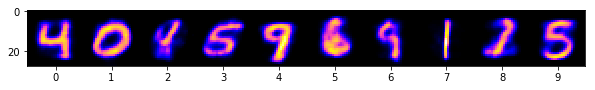

In [36]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)

generator = Model(decoder_input, _x_decoded_mean_squash) 
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))

for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 1 #activate a class
    predictions[:,i * img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))

plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

### e)

In [0]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

preds = np.zeros((10,10,28,28))

for i in range(10):
  activate_aux = np.zeros((10,10))
  activate_aux[:,i] = np.random.beta(5, 1, 10)
  preds[i] = np.squeeze(generator.predict(activate_aux))

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
  for j in range(10):
    axes[i][j].imshow(preds[j][i], cmap='gray')
    axes[i][j].get_xaxis().set_visible(False)
    axes[i][j].get_yaxis().set_visible(False)